# We have the problem that wind forcing seems to dominate changes to modal decomposition, rather than topo shape!

## In this notebook, compare the same time slices over 100hr average. Focus on mode 1. Make movies maybe?

In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta

# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft


client = tt.startdask()
client

<Client: 'tcp://127.0.0.1:35341' processes=7 threads=28, memory=112.00 GiB>


<Client: 'tcp://127.0.0.1:35341' processes=7 threads=28, memory=112.00 GiB>

## First draft a function to calculate N(z)

$ \large N = \frac{-g}{\rho}\frac{\partial \rho}{\partial z} $


In [40]:
trange = 50
to_process = {
    "full-20-2": {
        "data":tt.collect_data(
            exptname="full-20",
            lfiltered = "35560-lowpass"
        ).sel(yb = slice(-120,120)).drop_vars("cst").chunk({"zl":-1,"time":-1,"xb" : 50,"yb" : 50})
        },
    "full-20-1": {
        "data":tt.collect_data(
            exptname="full-20",
            lfiltered = "10000-lowpass"
        ).sel(yb = slice(-120,120)).drop_vars("cst").chunk({"zl":-1,"time":-1,"xb" : 50,"yb" : 50})
        },    
    "full-20-3": {
        "data":tt.collect_data(
            exptname="full-20",
            lfiltered = "40000-lowpass"
        ).sel(yb = slice(-120,120)).drop_vars("cst").chunk({"zl":-1,"time":-1,"xb" : 50,"yb" : 50})
        },

    "full-40": {
        "data":tt.collect_data(
            exptname="full-40",
            lfiltered = "10000-lowpass"
        ).sel(yb = slice(-120,120)).drop_vars("cst").chunk({"xb":-1,"time":-1,"xb" : 50,"yb" : 50})
        },
    "smooth-20": {
        "data":tt.collect_data(
            exptname="smooth-20",
            lfiltered = "10000-lowpass"
        ).sel(yb = slice(-120,120)).drop_vars("cst").chunk({"xb":-1,"time":-1,"xb" : 50,"yb" : 50})
        },
    "ideal-20": {
        "data":tt.collect_data(
            exptname="ideal-20",
            rawdata = ["rho","u","v"],
            timerange = (1000 - trange,1000 + trange)
        ).sel(yb = slice(-50,50))
    }
}


Timerange as inferred from lfiltered data: (35510.0, 35609.0)
Timerange as inferred from lfiltered data: (9950.0, 10049.0)
Timerange as inferred from lfiltered data: (39950.0, 40049.0)
Timerange as inferred from lfiltered data: (9950.0, 10049.0)
Timerange as inferred from lfiltered data: (9950.0, 10049.0)
loading rho...	done.
loading u...	done.
loading v...	done.


In [50]:
30000 / (24) // 365

3.0

In [6]:
## Load in the eigenfunctions

efuncs = {}

efuncs["full-20"] = xr.open_dataset("/g/data/nm03/ab8992/postprocessed/full-20/VerticalEigenfunctions.nc").chunk({"zl":-1,"xb" : 50,"yb" : 50})
efuncs["smooth-20"] = xr.open_dataset("/g/data/nm03/ab8992/postprocessed/smooth-20/VerticalEigenfunctions.nc").chunk({"zl":-1,"xb" : 50,"yb" : 50})
efuncs["full-40"] = xr.open_dataset("/g/data/nm03/ab8992/postprocessed/full-40/VerticalEigenfunctions.nc").chunk({"zl":-1,"xb" : 50,"yb" : 50})
efuncs["ideal-20"] = tt.ShootingVmodes(
    xr.merge(
        [
            to_process["ideal-20"]["data"].bathy.rename("H"),
            tt.getN(to_process["ideal-20"]["data"].rho).rename("N").mean("time")
        ]).sel(xb = slice(400,405),yb = slice(0,5)).load().chunk({"xb":1,"yb":1})
)


In [47]:
print("U20")
to_process["full-20-1"]["U"]  = (efuncs["full-20"].U * to_process["full-20-1"]["data"].u).fillna(0).integrate("zl").load() 
to_process["full-20-1"]["V"]  = (efuncs["full-20"].U * to_process["full-20-1"]["data"].v).fillna(0).integrate("zl").load() 
to_process["full-20-2"]["U"]  = (efuncs["full-20"].U * to_process["full-20-2"]["data"].u).fillna(0).integrate("zl").load() 
to_process["full-20-2"]["V"]  = (efuncs["full-20"].U * to_process["full-20-2"]["data"].v).fillna(0).integrate("zl").load() 
to_process["full-20-3"]["U"]  = (efuncs["full-20"].U * to_process["full-20-3"]["data"].u).fillna(0).integrate("zl").load() 
to_process["full-20-3"]["V"]  = (efuncs["full-20"].U * to_process["full-20-3"]["data"].v).fillna(0).integrate("zl").load() 

print("U40")
to_process["full-40"]["U"]  = (efuncs["full-40"].U * to_process["full-40"]["data"].u).fillna(0).integrate("zl").load() 
to_process["full-40"]["V"]  = (efuncs["full-40"].U * to_process["full-40"]["data"].v).fillna(0).integrate("zl").load()
to_process["ideal-20"]["U"] = (efuncs["ideal-20"].U.isel(xb = 0,yb = 0).drop(["xb","yb"]) * to_process["ideal-20"]["data"].u).fillna(0).integrate("zl").load() 
to_process["ideal-20"]["V"] = (efuncs["ideal-20"].U.isel(xb = 0,yb = 0).drop(["xb","yb"]) * to_process["ideal-20"]["data"].v).fillna(0).integrate("zl").load() 

to_process["smooth-20"]["U"]  = (efuncs["smooth-20"].U * to_process["smooth-20"]["data"].u).fillna(0).integrate("zl").load() 
to_process["smooth-20"]["V"]  = (efuncs["smooth-20"].U * to_process["smooth-20"]["data"].v).fillna(0).integrate("zl").load()


U20
U40


/jobfs/121610039.gadi-pbs/ipykernel_2509264/4060670134.py:12: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  to_process["ideal-20"]["U"] = (efuncs["ideal-20"].U.isel(xb = 0,yb = 0).drop(["xb","yb"]) * to_process["ideal-20"]["data"].u).fillna(0).integrate("zl").load()
/jobfs/121610039.gadi-pbs/ipykernel_2509264/4060670134.py:13: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  to_process["ideal-20"]["V"] = (efuncs["ideal-20"].U.isel(xb = 0,yb = 0).drop(["xb","yb"]) * to_process["ideal-20"]["data"].v).fillna(0).integrate("zl").load()


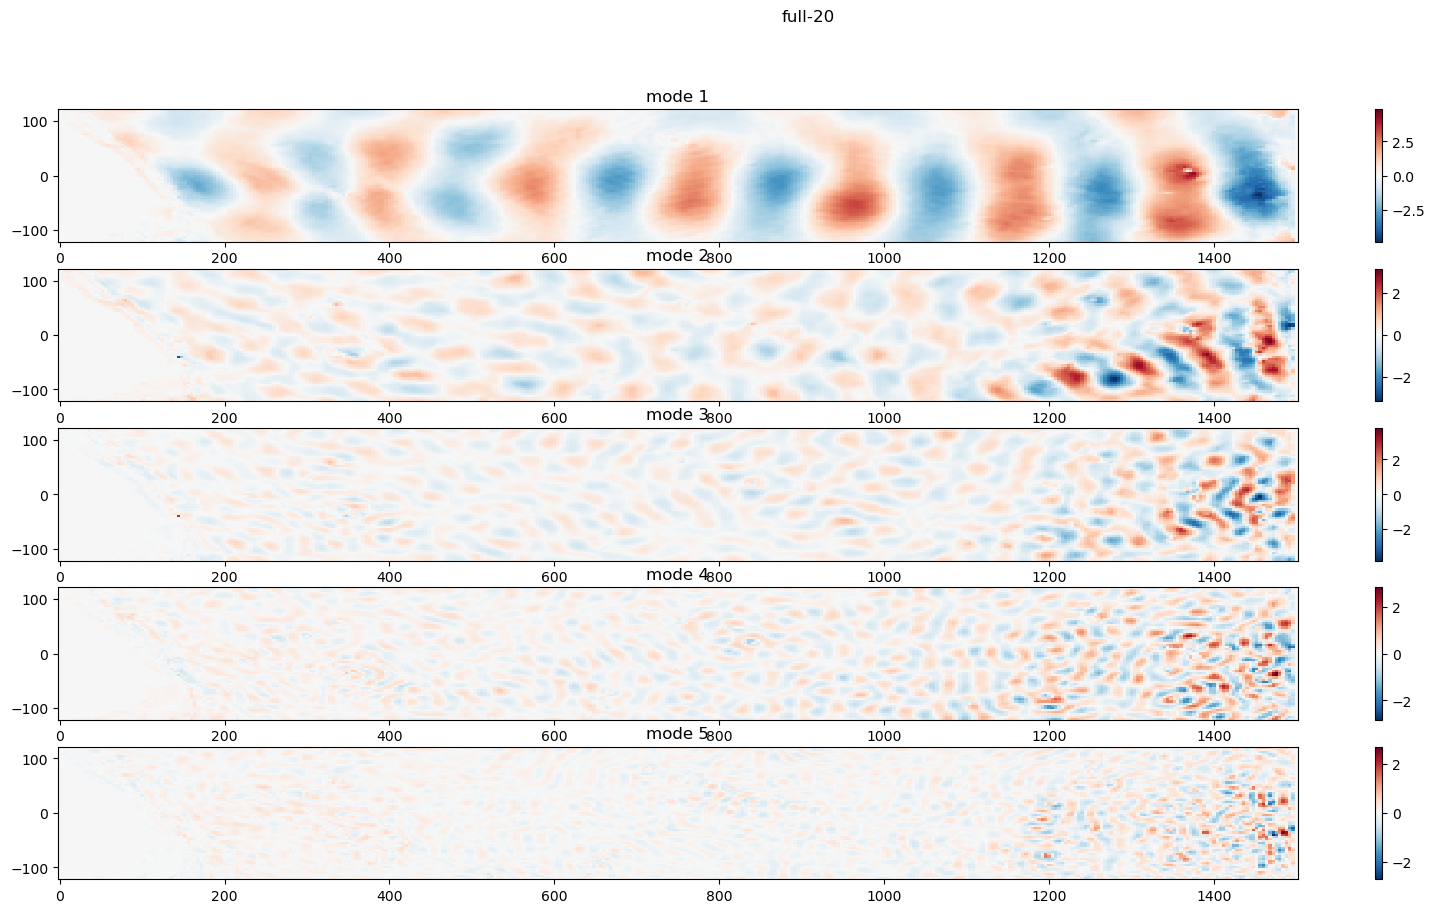

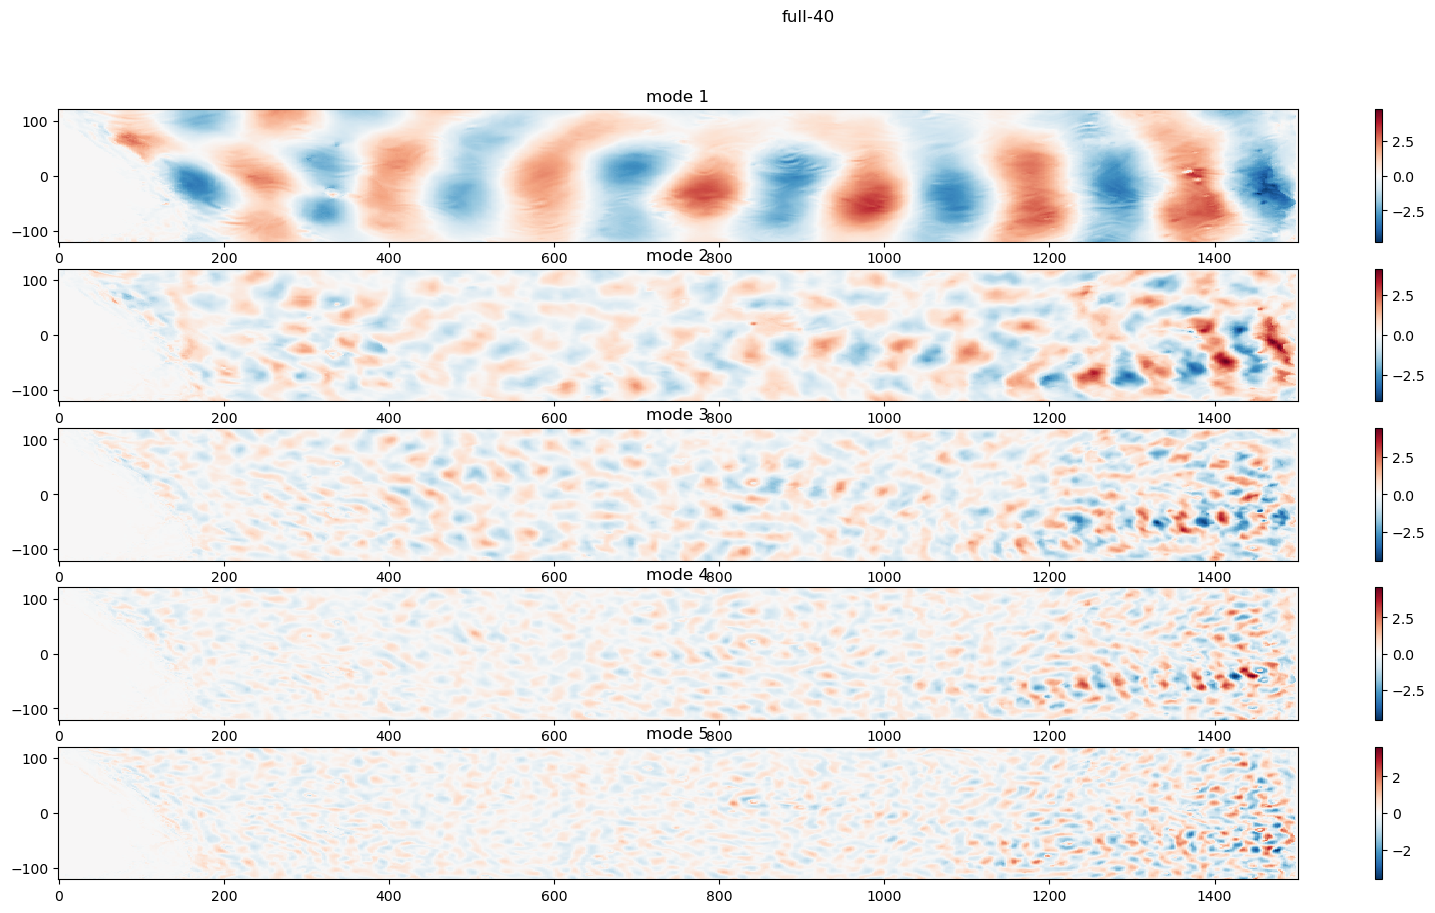

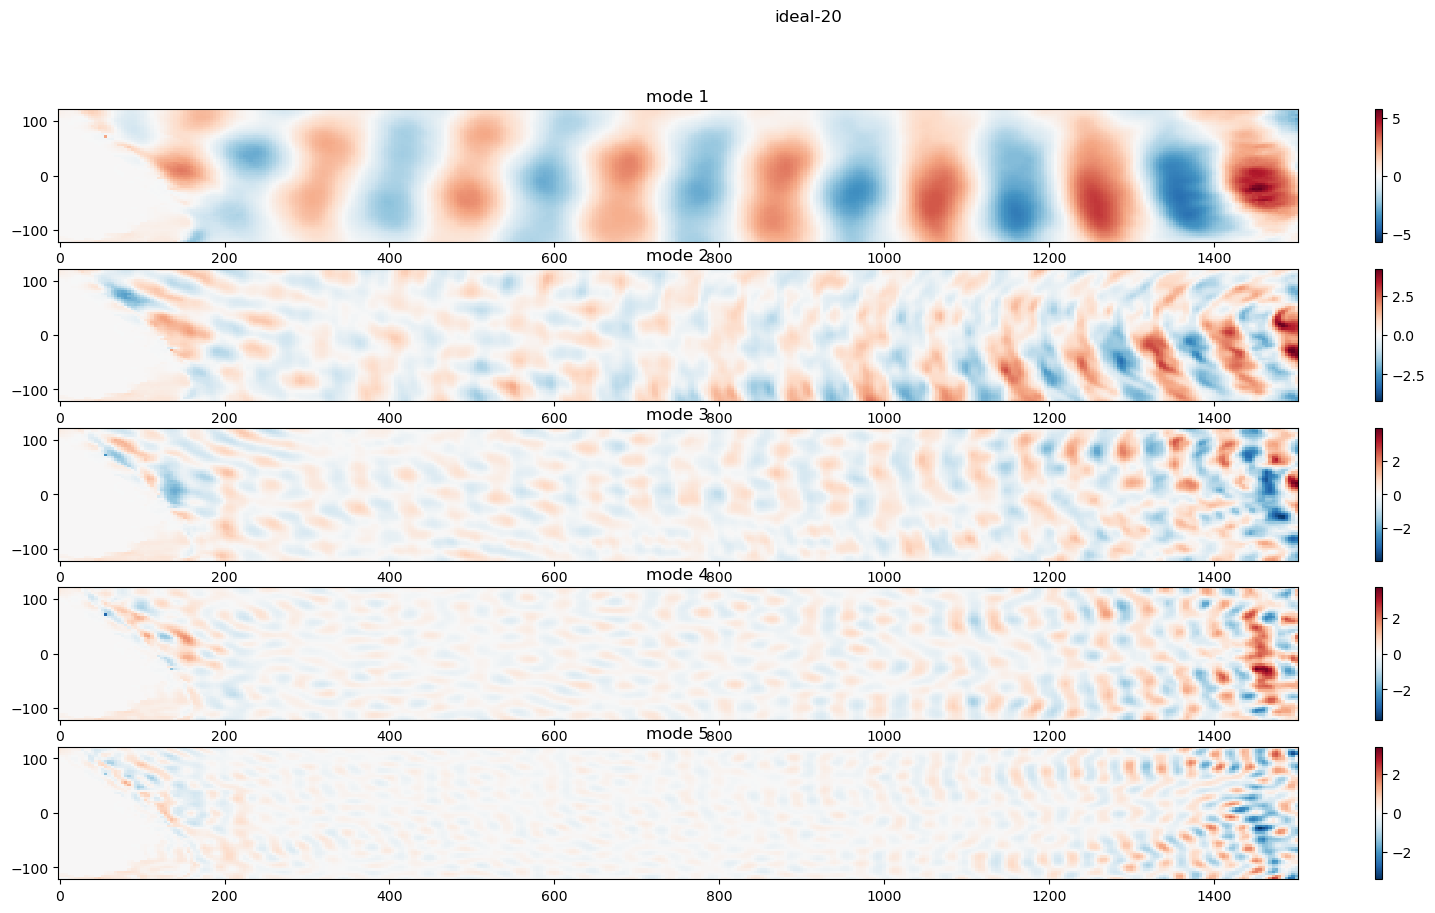

In [7]:

for expt in to_process:
    vmodes = to_process[expt]["U"]
    fig,ax = plt.subplots(5,figsize = (20,10))

    for mode in range(len(vmodes.mode)):
        fig.suptitle(expt)
        vmodes.isel(time = 50,mode = mode).plot(ax = ax[mode])    
        ax[mode].set_xlabel("")
        ax[mode].set_ylabel("")
        ax[mode].set_title(f"mode {mode + 1}")


In [9]:
def DirectionalFilter(data):
    """
    Fourier filter into forward and backward propagating signals
    """
    import xrft
    FT = xrft.fft(
        data.drop_vars(['lon', 'lat']).sel(xb = slice(200,None)),dim = ["time","xb"]
    ).load()

    ft = np.real(xrft.ifft(
        FT,dim = ["freq_time","freq_xb"]
    ))

    forward = np.real(xrft.ifft(
        FT.where((FT.freq_xb >= 0) & (FT.freq_time >= 0), 0) + FT.where((FT.freq_xb <= 0) & (FT.freq_time <= 0), 0) - FT.where((FT.freq_xb == 0) & (FT.freq_time == 0), 0),
        dim = ["freq_time","freq_xb"]
    ))

    backward = np.real(xrft.ifft(
        FT.where((FT.freq_xb <= 0) & (FT.freq_time >= 0), 0) + FT.where((FT.freq_xb >= 0) & (FT.freq_time <= 0), 0) - FT.where((FT.freq_xb == 0) & (FT.freq_time == 0), 0),
        dim = ["freq_time","freq_xb"]
    ))

    return xr.merge([forward.rename(f"{data.name}_forward"),backward.rename(f"{data.name}_backward")])


## Plot full20 with full40 at same point in time

Text(0.5, 1.0, 'Compare KE along beam:\n 20th vs 40th degree')

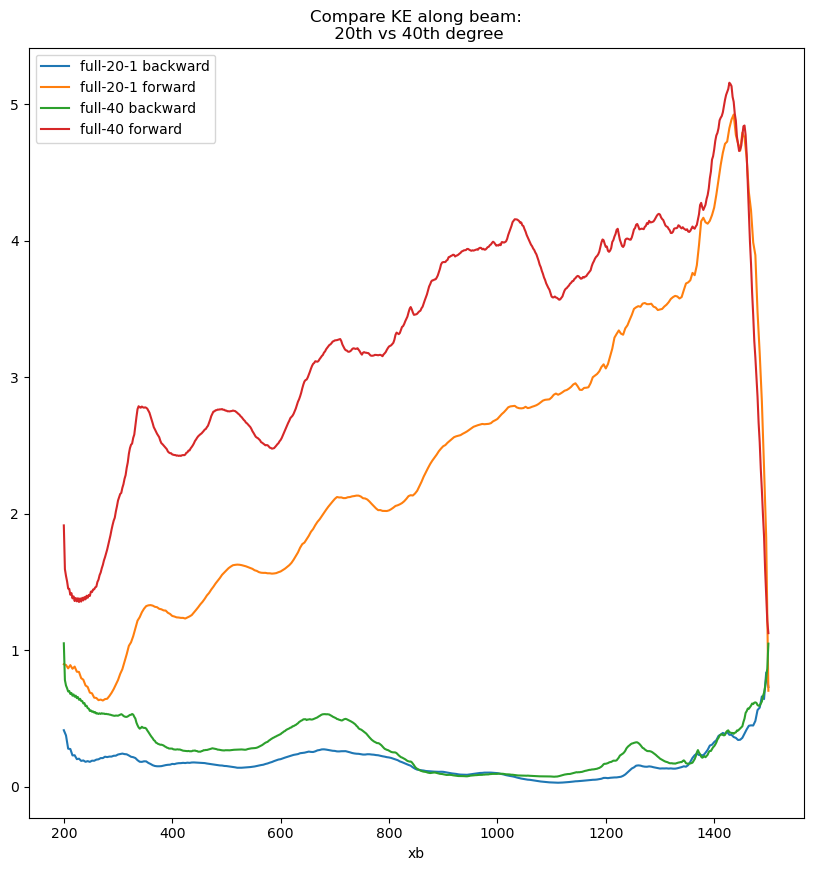

In [48]:
import warnings

# Suppress future warnings from xrft
warnings.filterwarnings("ignore", category=FutureWarning, module="xrft")

fig,ax = plt.subplots(1,figsize = (10,10))
mode = 0
for expt in ["full-20-1","full-40"]:
    uFiltered = DirectionalFilter(to_process[expt]["U"].rename("u").cumsum("mode").isel(mode = mode))
    vFiltered = DirectionalFilter(to_process[expt]["V"].rename("v").cumsum("mode").isel(mode = mode))

    ke_forward = (uFiltered.u_forward**2 + vFiltered.v_forward**2).mean("time").mean("yb")
    ke_backward = (uFiltered.u_backward**2 + vFiltered.v_backward**2).mean("time").mean("yb")

    ke_backward.plot(ax = ax,label = f"{expt} backward")
    ke_forward.plot(ax = ax,label = f"{expt} forward")
    ax.legend()

ax.set_title("Compare KE along beam:\n 20th vs 40th degree")


Text(0.5, 1.0, 'Compare KE along beam:\n Effect of topography')

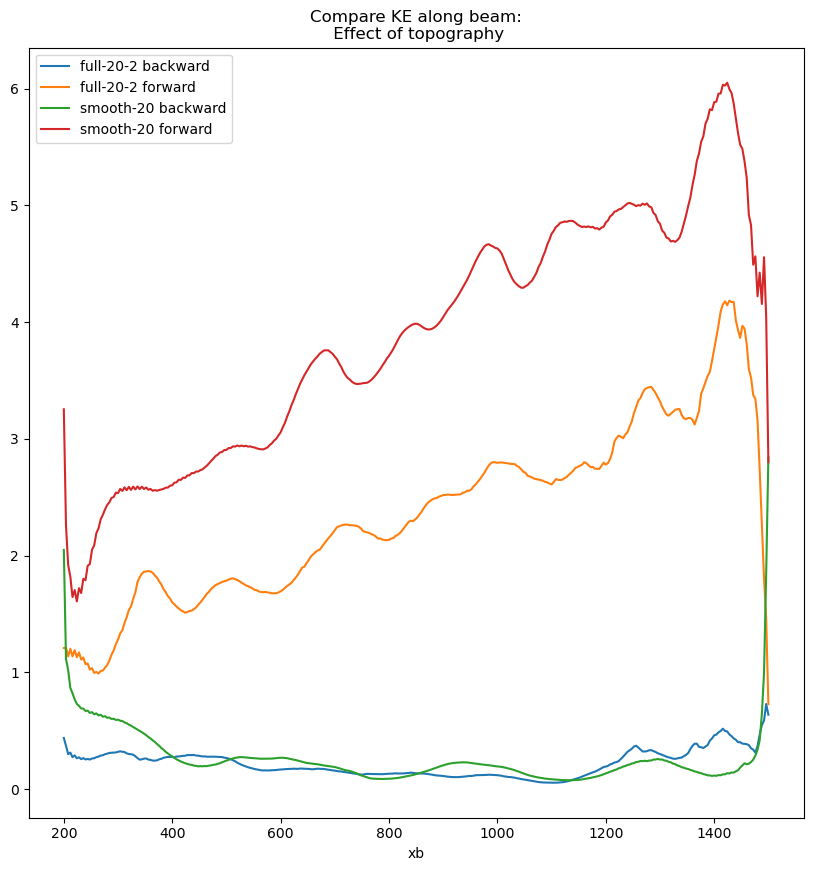

In [22]:
import warnings

# Suppress future warnings from xrft
warnings.filterwarnings("ignore", category=FutureWarning, module="xrft")

fig,ax = plt.subplots(1,figsize = (10,10))
mode = 0
for expt in ["full-20-2","smooth-20"]:
    uFiltered = DirectionalFilter(to_process[expt]["U"].rename("u").cumsum("mode").isel(mode = mode))
    vFiltered = DirectionalFilter(to_process[expt]["V"].rename("v").cumsum("mode").isel(mode = mode))

    ke_forward = (uFiltered.u_forward**2 + vFiltered.v_forward**2).mean("time").mean("yb")
    ke_backward = (uFiltered.u_backward**2 + vFiltered.v_backward**2).mean("time").mean("yb")

    ke_backward.plot(ax = ax,label = f"{expt} backward")
    ke_forward.plot(ax = ax,label = f"{expt} forward")
    ax.legend()
ax.set_title("Compare KE along beam:\n Effect of topography")


full-20-2
full-20-1
full-20-3


Text(0.5, 1.0, 'Compare KE along beam:\n Temporal variation. 2: 2y11m 3: 3y6m')

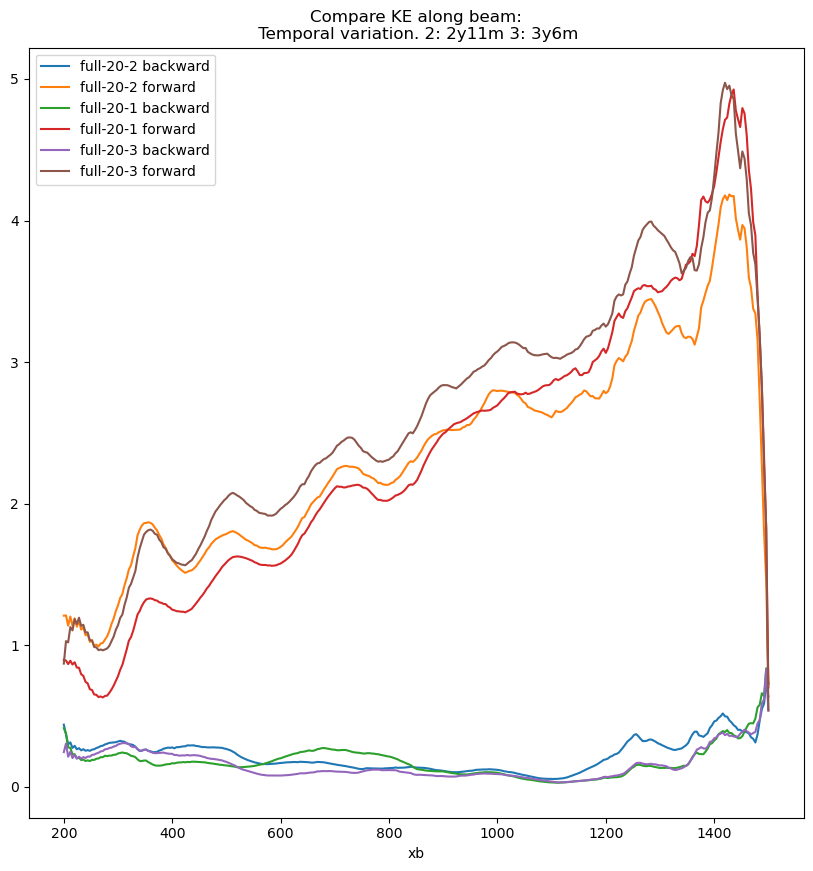

In [51]:
import warnings

# Suppress future warnings from xrft
warnings.filterwarnings("ignore", category=FutureWarning, module="xrft")

fig,ax = plt.subplots(1,figsize = (10,10))
mode = 0
for expt in ["full-20-2","full-20-1","full-20-3"]:
    print(expt)
    uFiltered = DirectionalFilter(to_process[expt]["U"].rename("u").cumsum("mode").isel(mode = mode))
    vFiltered = DirectionalFilter(to_process[expt]["V"].rename("v").cumsum("mode").isel(mode = mode))

    ke_forward = (uFiltered.u_forward**2 + vFiltered.v_forward**2).mean("time").mean("yb")
    ke_backward = (uFiltered.u_backward**2 + vFiltered.v_backward**2).mean("time").mean("yb")

    ke_backward.plot(ax = ax,label = f"{expt} backward")
    ke_forward.plot(ax = ax,label = f"{expt} forward")
    ax.legend()
ax.set_title("Compare KE along beam:\n Temporal variation. 2: 2y11m 3: 3y6m")


In [ ]:
import warnings

# Suppress future warnings from xrft
warnings.filterwarnings("ignore", category=FutureWarning, module="xrft")

fig,ax = plt.subplots(1,figsize = (10,10))
mode = 0
for expt in ["full-20-2","smooth-20"]:
    uFiltered = DirectionalFilter(to_process[expt]["U"].rename("u").cumsum("mode").isel(mode = mode))
    vFiltered = DirectionalFilter(to_process[expt]["V"].rename("v").cumsum("mode").isel(mode = mode))

    ke_forward = (uFiltered.u_forward**2 + vFiltered.v_forward**2).mean("time").mean("yb")
    ke_backward = (uFiltered.u_backward**2 + vFiltered.v_backward**2).mean("time").mean("yb")

    ke_backward.plot(ax = ax,label = f"{expt} backward")
    ke_forward.plot(ax = ax,label = f"{expt} forward")
    ax.legend()
ax.set_title("Compare KE along beam:\n Effect of topography")


## Check general conservation of energy:

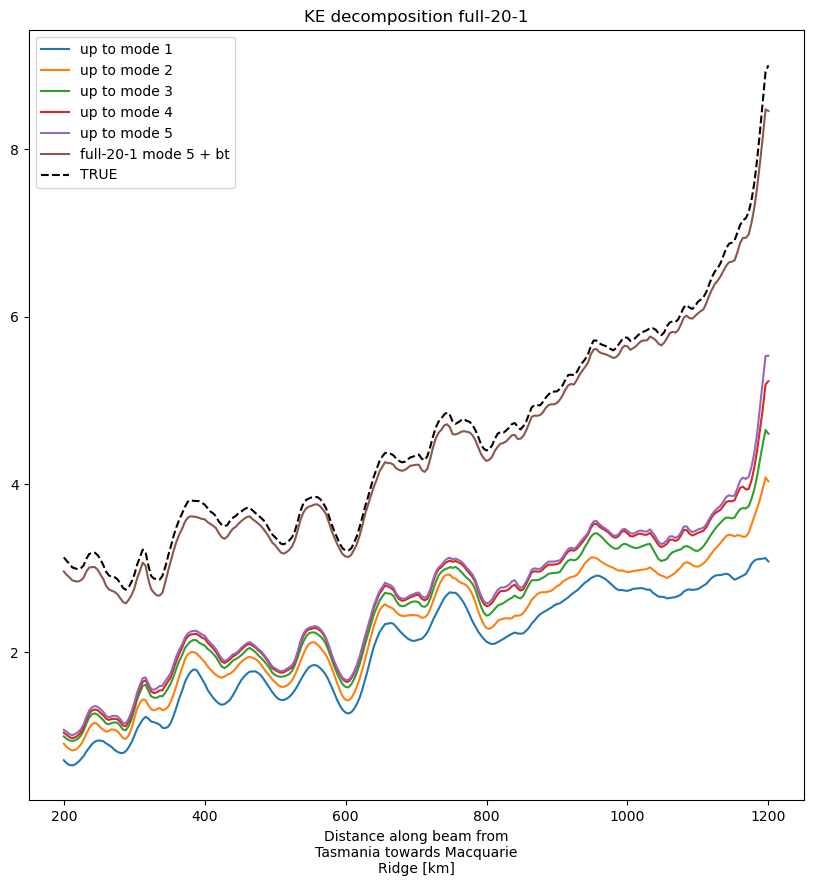

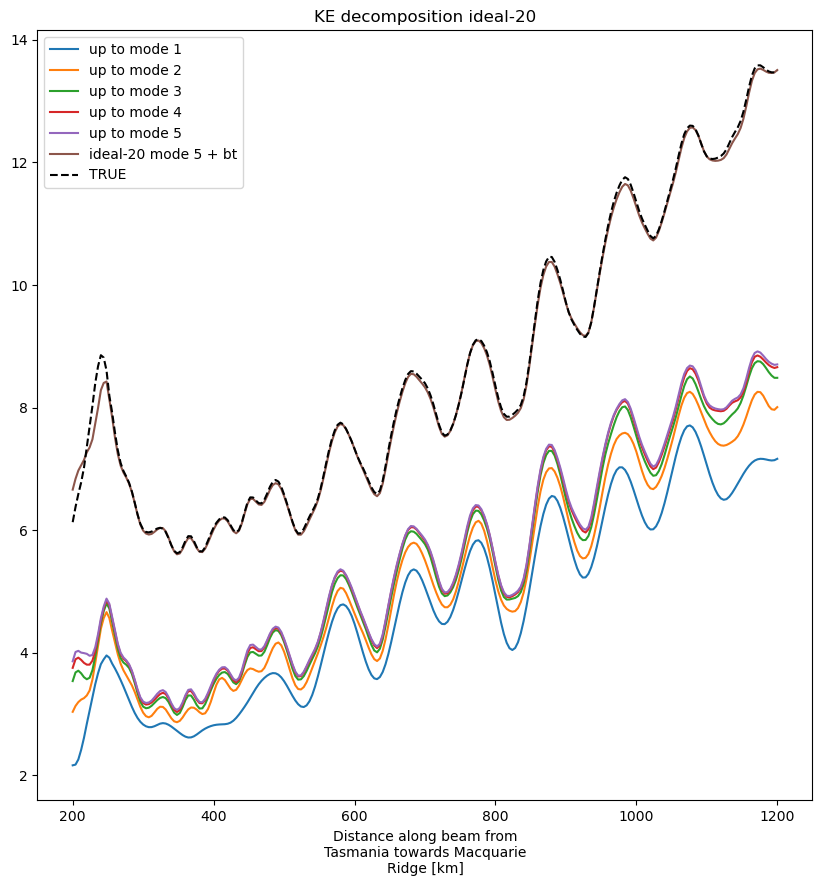

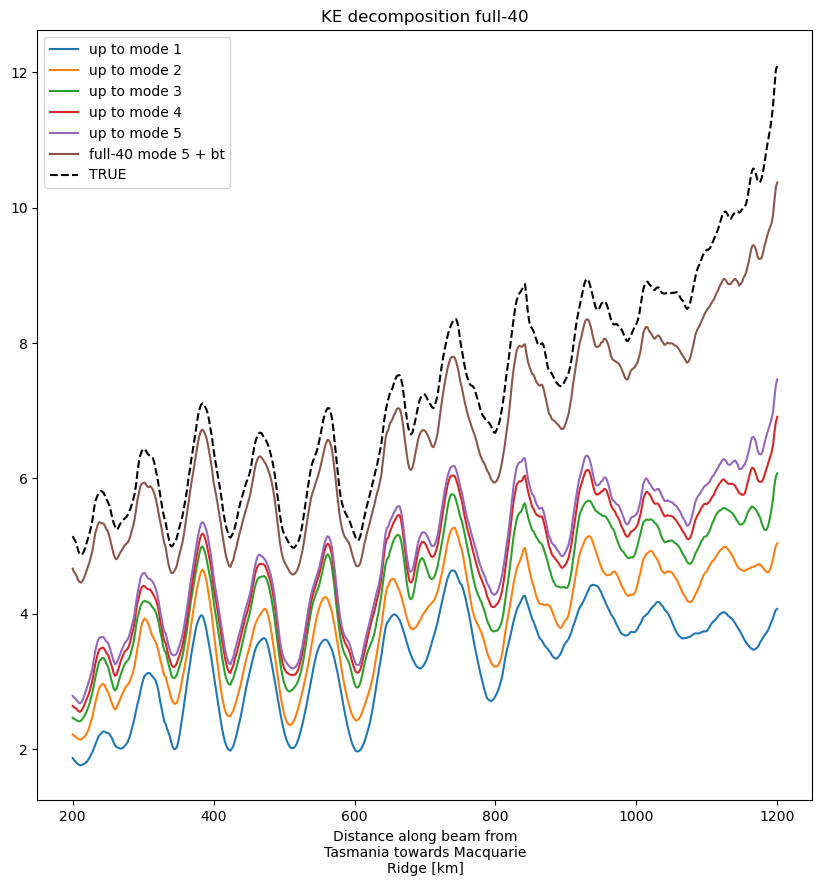

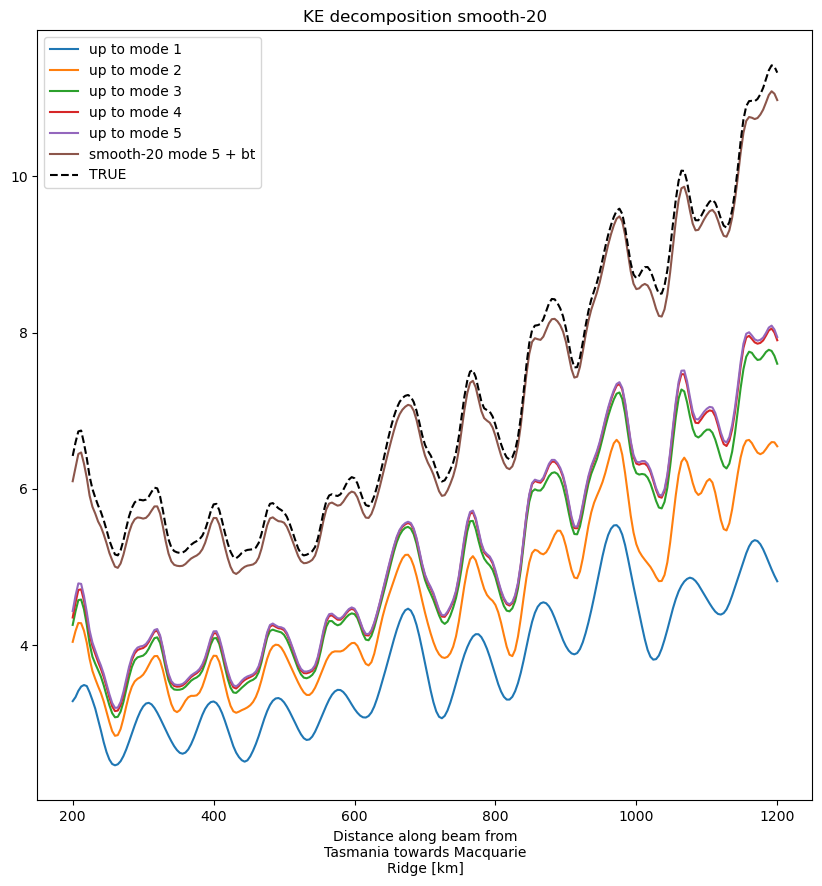

In [53]:
# def getBT(data):

for expt in ["full-20-1","ideal-20","full-40","smooth-20"]:
    fig,ax = plt.subplots(1,figsize = (10,10))

    ke = (to_process[expt]["U"]**2 + to_process[expt]["V"]**2).mean("yb").mean("time").cumsum("mode")
    ke_true = (to_process[expt]["data"].u.fillna(0)**2 + to_process[expt]["data"].v.fillna(0)**2).mean("yb").mean("time").integrate("zl")
    H = np.abs(to_process[expt]["data"].bathy)
    ubt = to_process[expt]["data"].u.fillna(0).integrate("zl")/H
    vbt = to_process[expt]["data"].v.fillna(0).integrate("zl")/H

    ke_bt = ((ubt**2 + vbt**2) * H).mean("yb").mean("time")

    # ke_bt = ((to_process[expt]["data"].u.integrate("zl")/to_process[expt]["data"].bathy)**2 + (to_process[expt]["data"].v.integrate("zl")/to_process[expt]["data"].bathy)**2).mean("yb").mean("time")

    for i in range(5):
        ke.isel(mode = i).sel(xb = slice(200,1200)).plot(ax = ax,label = f"up to mode {1+ i}")

    (ke.isel(mode = -1) + ke_bt).sel(xb = slice(200,1200)).plot(ax = ax,label = f"{expt} mode 5 + bt")
    ke_true.sel(xb = slice(200,1200)).plot(ax = ax,color = "black",linestyle = "--",label = "TRUE")
    ax.set_xlim
    ax.legend()
    ax.set_title(f"KE decomposition {expt}")

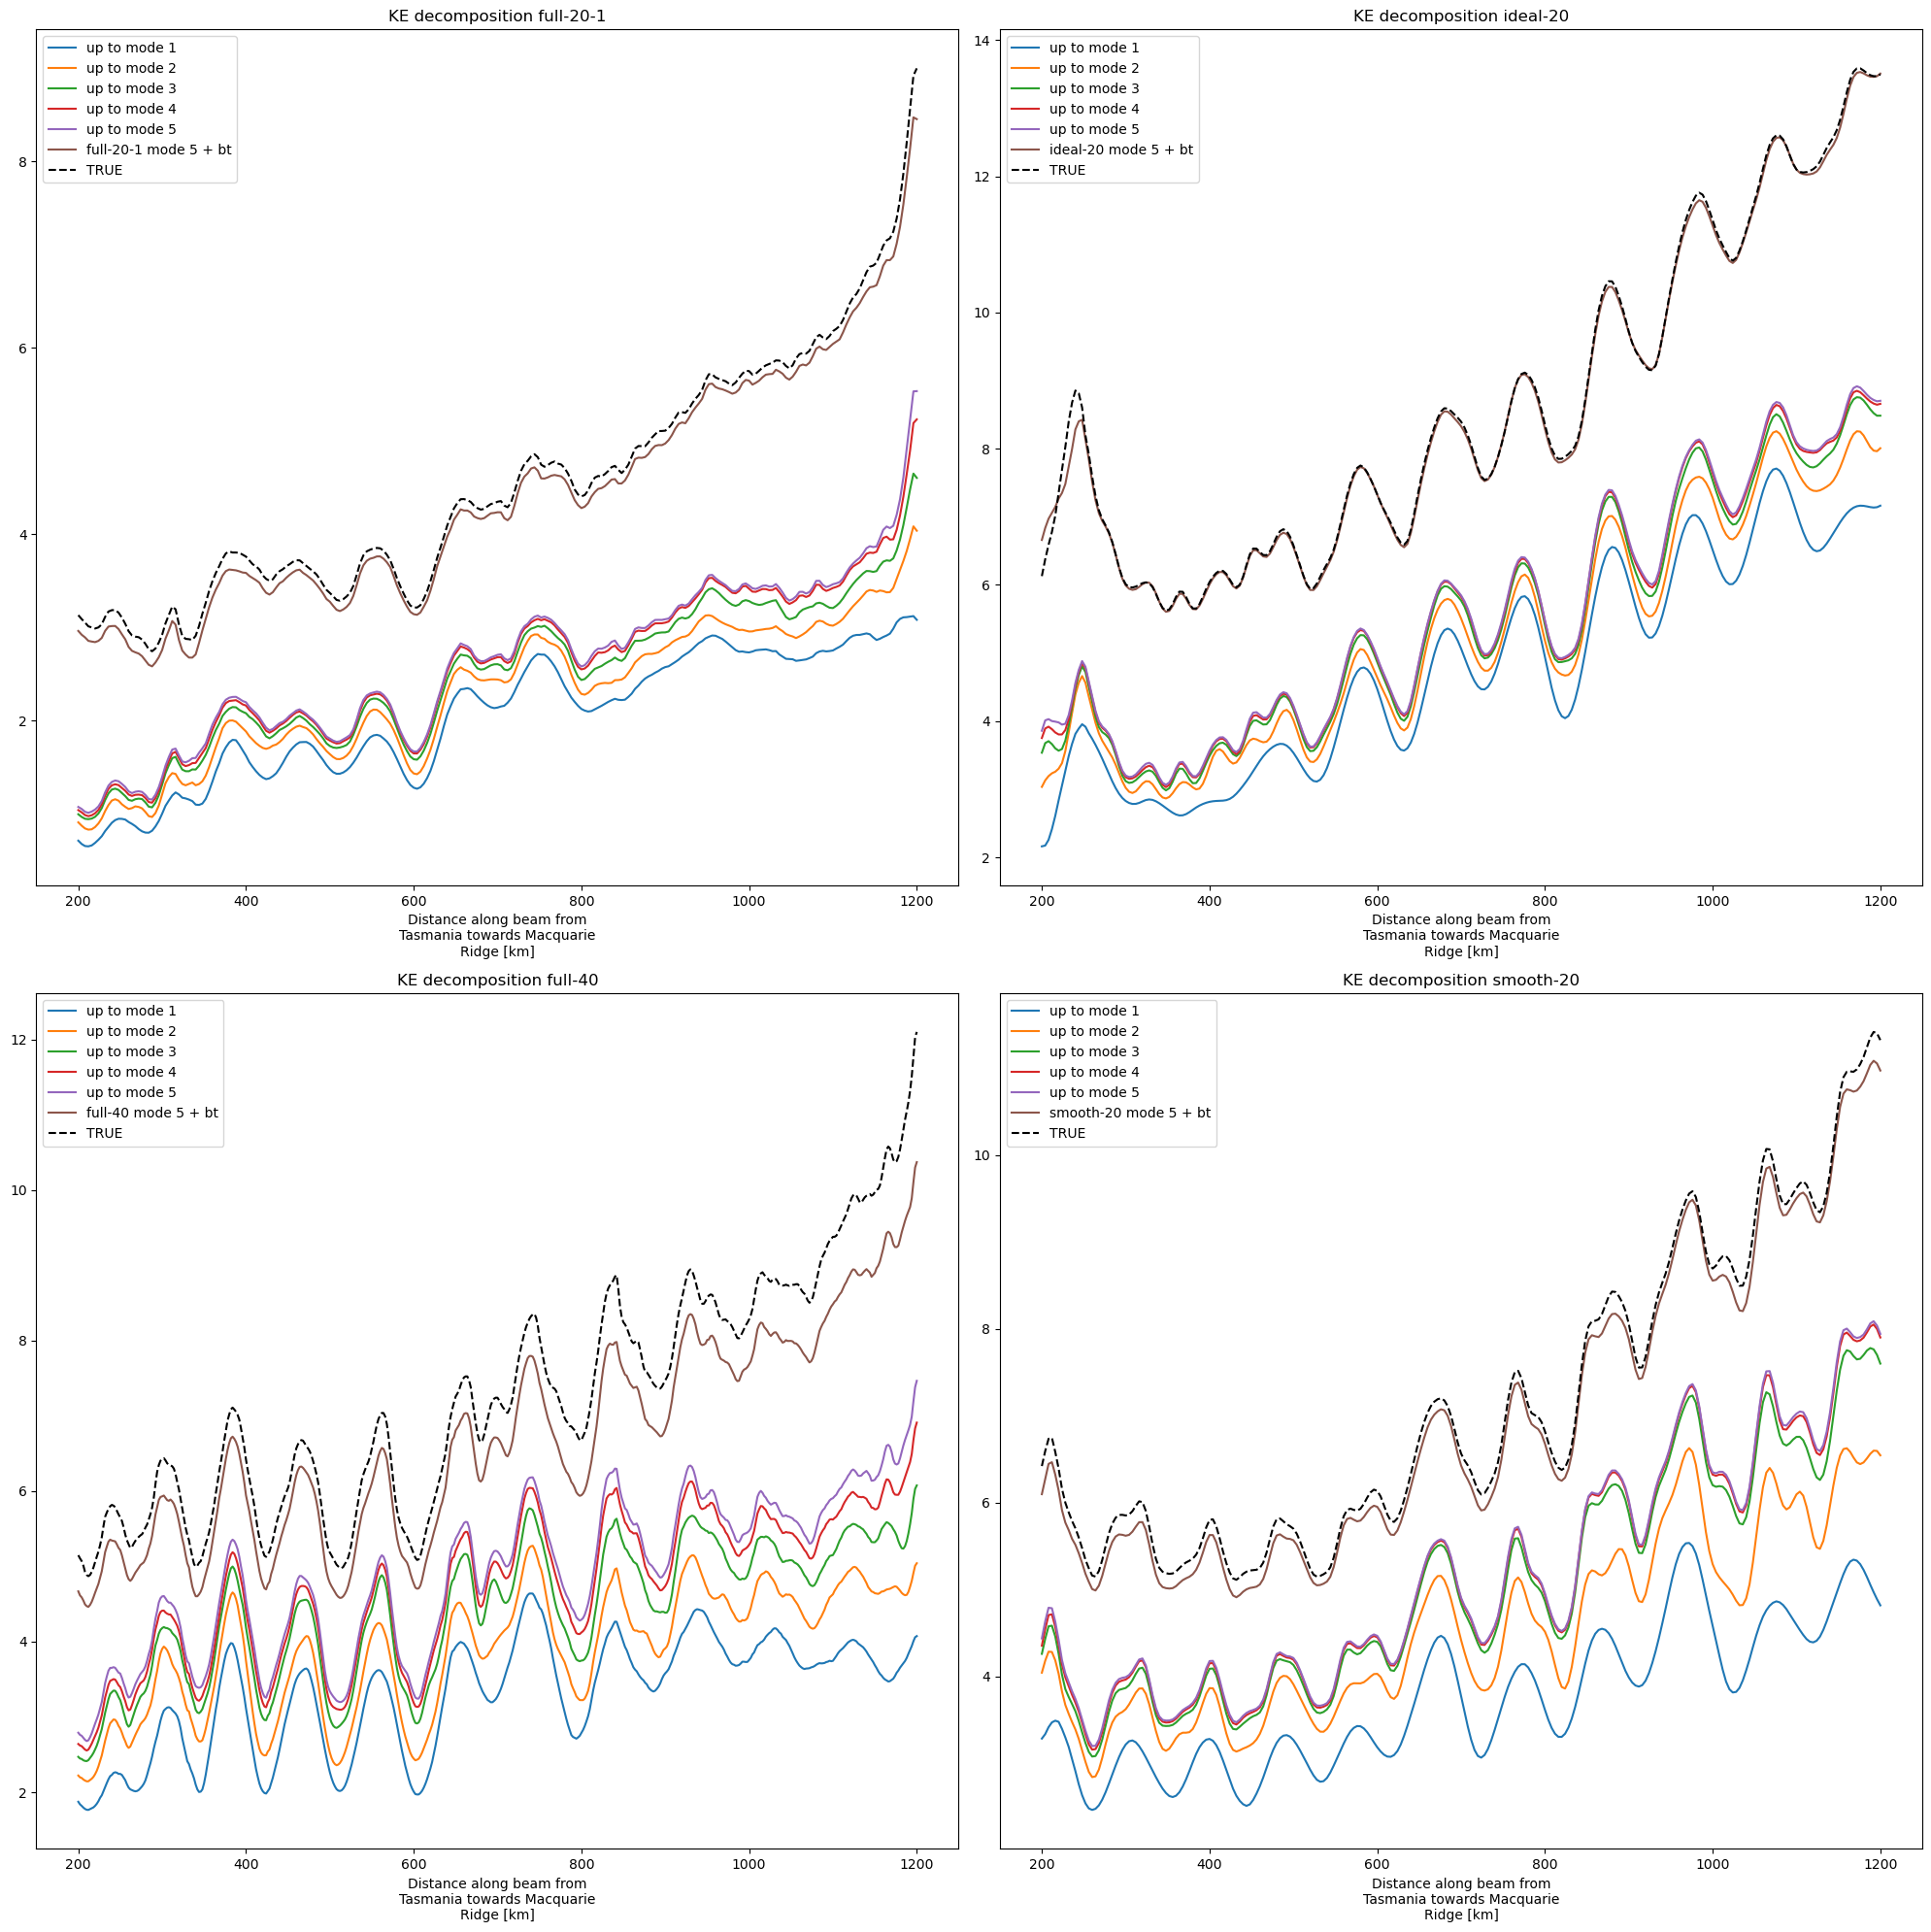

In [54]:
import matplotlib.pyplot as plt

# Create a 2x2 grid of plots
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
axes = axes.flatten()  # Flatten the 2x2 grid to easily iterate over it

for idx, expt in enumerate(["full-20-1", "ideal-20", "full-40", "smooth-20"]):
    ax = axes[idx]  # Select the current axis

    ke = (to_process[expt]["U"]**2 + to_process[expt]["V"]**2).mean("yb").mean("time").cumsum("mode")
    ke_true = (to_process[expt]["data"].u.fillna(0)**2 + to_process[expt]["data"].v.fillna(0)**2).mean("yb").mean("time").integrate("zl")
    H = np.abs(to_process[expt]["data"].bathy)
    ubt = to_process[expt]["data"].u.fillna(0).integrate("zl") / H
    vbt = to_process[expt]["data"].v.fillna(0).integrate("zl") / H

    ke_bt = ((ubt**2 + vbt**2) * H).mean("yb").mean("time")

    for i in range(5):
        ke.isel(mode=i).sel(xb=slice(200, 1200)).plot(ax=ax, label=f"up to mode {1 + i}")

    (ke.isel(mode=-1) + ke_bt).sel(xb=slice(200, 1200)).plot(ax=ax, label=f"{expt} mode 5 + bt")
    ke_true.sel(xb=slice(200, 1200)).plot(ax=ax, color="black", linestyle="--", label="TRUE")
    
    ax.legend()
    ax.set_title(f"KE decomposition {expt}")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Vertical Mode Movie



In [66]:
def PlotForMovie(data):
    fig,ax = plt.subplots(5,2,figsize = (30,18))

    for i in range(len(data.mode)):

        data["u"].isel(mode = i).sel(xb = slice(0,1400)).plot(ax = ax[i,0],add_colorbar = False)
        data["v"].isel(mode = i).sel(xb = slice(0,1400)).plot(ax = ax[i,1],add_colorbar = False)
        tt.plot_topo(ax[i,0],bathy = data.bathy)
        tt.plot_topo(ax[i,1],bathy = data.bathy)
        ax[i,0].set_xlim(0,1400)
        ax[i,1].set_xlim(0,1400)
        ax[i,0].set_title("")
        ax[i,1].set_title("")
        ax[i,0].set_xlabel("")
        ax[i,1].set_ylabel("")
        ax[i,1].set_yticks([])
        ax[i,1].set_xlabel("")
        ax[i,0].set_ylabel("Distance to beam centre (km)")
        ax[i, 0].set_aspect('auto')
        ax[i, 1].set_aspect('auto')

    ax[-1,0].set_xlabel("Distance from Tas (km)")
    ax[-1,1].set_xlabel("Distance from Tas (km)")
    fig.subplots_adjust(wspace=0.01)
    ax[0,0].set_title("u mode 1")
    ax[0,1].set_title("v mode 1")
    return fig

# fig = PlotForMovie(
#     ]))

# data = xr.merge([
#     to_process["smooth-20"]["U"].rename("u"),
#     to_process["smooth-20"]["V"].rename("v"),
#     to_process["smooth-20"]["data"].bathy.sel(yb = slice(-120,120))
# ]).load().chunk({"time":1})

tt.make_movie(
    data,
    PlotForMovie,
    "smooth-20",
    "vertical_modes",
    parallel = True
)


# data = xr.merge([
#     to_process["full-20"]["U"].rename("u"),
#     to_process["full-20"]["V"].rename("v"),
#     to_process["full-20"]["data"].bathy.sel(yb = slice(-120,120))
# ]).load().chunk({"time":1})

# tt.make_movie(
#     data,
#     PlotForMovie,
#     "full-20",
#     "vertical_modes",
#     parallel = True
# )

# data = xr.merge([
#     to_process["ideal-20"]["U"].rename("u"),
#     to_process["ideal-20"]["V"].rename("v"),
#     to_process["ideal-20"]["data"].bathy.sel(yb = slice(-120,120))
# ]).load().chunk({"time":1})

# tt.make_movie(
#     data,
#     PlotForMovie,
#     "ideal-20",
#     "vertical_modes",
#     parallel = True
# )


Making movie vertical_modes for smooth-20
/g/data/v45/ab8992/movies_tmp/tasman-tides/smooth-20/movies/vertical_modes


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 175.70 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


ffmpeg -r 5  -i /g/data/v45/ab8992/movies_tmp/tasman-tides/smooth-20/movies/vertical_modes/frame_%05d.png -s 1920x1080 -c:v libx264 -pix_fmt yuv420p /g/data/v45/ab8992/dropbox/tasman-tides/smooth-20/moviesvertical_modes.mp4
ffmpeg finished with returncode 0 

 and output 


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux

In [64]:
data.bathy

<xarray.DataArray 'bathy' (yb: 61, xb: 376)> Size: 183kB
dask.array<xarray-bathy, shape=(61, 376), dtype=float64, chunksize=(61, 376), chunktype=numpy.ndarray>
Coordinates:
  * xb       (xb) float64 3kB -0.0 4.0 8.0 12.0 ... 1.492e+03 1.496e+03 1.5e+03
  * yb       (yb) float64 488B -120.0 -116.0 -112.0 -108.0 ... 112.0 116.0 120.0
    zi       float64 8B 10.79
    lon      (yb, xb) float64 183kB dask.array<chunksize=(61, 376), meta=np.ndarray>
    lat      (yb, xb) float64 183kB dask.array<chunksize=(61, 376), meta=np.ndarray>

In [63]:
to_process["full-20-1"]["data"].bathy

<xarray.DataArray 'bathy' (yb: 61, xb: 376)> Size: 183kB
dask.array<rechunk-merge, shape=(61, 376), dtype=float64, chunksize=(50, 50), chunktype=numpy.ndarray>
Coordinates:
  * xb       (xb) float64 3kB -0.0 4.0 8.0 12.0 ... 1.492e+03 1.496e+03 1.5e+03
  * yb       (yb) float64 488B -120.0 -116.0 -112.0 -108.0 ... 112.0 116.0 120.0
    lon      (yb, xb) float64 183kB dask.array<chunksize=(50, 50), meta=np.ndarray>
    lat      (yb, xb) float64 183kB dask.array<chunksize=(50, 50), meta=np.ndarray>
Attributes:
    Description:  Beamwidth 400km, Beamlength 1500km, Resolution 4.0km, angle...

In [65]:
data.bathy[:,:] = to_process["full-20-1"]["data"].bathy[:,:]

In [5]:
# for d in ["full-20","smooth-20"]:
for d in ["smooth-20"]:
    data = tt.collect_data(
            exptname=d,
            rawdata = ["rho"],
            lfiltered = "10000-lowpass"
        ).drop("cst").chunk({"zl":-1}).sel(xb = slice(0,1200)).persist()
    tt.make_movie(
        VerticalModes(data).load(),
        PlotForMovie,
        d,
        "vertical_modes_fulldomain"
    )

    

Timerange as inferred from lfiltered data: (9950.0, 10049.0)
loading rho...	done.


/jobfs/118778567.gadi-pbs/ipykernel_1919365/479221704.py:7: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  ).drop("cst").chunk({"zl":-1}).sel(xb = slice(0,1200)).persist()
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/dask/array/core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 17
  result = blockwise(
/g/data

2024-06-21 10:06:57,576 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-u-856d072b98cb891f58f5f62fa3ea6bf6' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x151dc537add0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.netCDF4_.NetCDF4ArrayWrapper object at 0x151cdcb423c0>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None), slice(None, None, None)))))),), {})
new run_spec: (<function execute_task at 0x151dc537add0>, (ImplicitToExplicitIndexingAdapte

Making movie vertical_modes_fulldomain for smooth-20
/g/data/v45/ab8992/movies_tmp/tasman-tides/smooth-20/movies/vertical_modes_fulldomain
ffmpeg -r 5  -i /g/data/v45/ab8992/movies_tmp/tasman-tides/smooth-20/movies/vertical_modes_fulldomain/frame_%05d.png -s 1920x1080 -c:v libx264 -pix_fmt yuv420p /g/data/v45/ab8992/dropbox/tasman-tides/smooth-20/moviesvertical_modes_fulldomain.mp4
ffmpeg finished with returncode 0 

 and output 


ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 11.3.0 (conda-forge gcc 11.3.0-19)
  configuration: --prefix=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_plac --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1674566204550/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmp

In [ ]:
trange = 50

for d in ["blank-20","ideal-20"]:
    data = tt.collect_data(
            exptname=d,
            rawdata = ["rho","u","v"],
            timerange = (1000 - trange,1000 + trange).chunk({"zl":-1,"time":10}).sel(xb = slice(0,1200)).persist()
    )
    tt.make_movie(
        VerticalModes(data).load(),
        PlotForMovie,
        d,
        "vertical_modes_fulldomain"
    )


In [83]:
expt = "blank-20"
t0 = 1000

data = tt.collect_data(
        exptname=expt,
        rawdata = ["rho"],
        timerange = (t0,t0 + 4000)
    ).sel(yb = slice(-120,120))

loading rho...	done.


In [4]:
trange = 50
to_process = {
    "full-20-2": {
        "data":tt.collect_data(
            exptname="full-20",
            lfiltered = "35560-lowpass"
        ).sel(yb = slice(-120,120)).drop_vars("cst").chunk({"zl":-1,"time":-1,"xb" : 50,"yb" : 50})
        },
    # "full-20-1": {
    #     "data":tt.collect_data(
    #         exptname="full-20",
    #         lfiltered = "10000-lowpass"
    #     ).sel(yb = slice(-120,120)).drop_vars("cst").chunk({"zl":-1,"time":-1,"xb" : 50,"yb" : 50})
    #     },    
    # "full-20-3": {
    #     "data":tt.collect_data(
    #         exptname="full-20",
    #         lfiltered = "40000-lowpass"
    #     ).sel(yb = slice(-120,120)).drop_vars("cst").chunk({"zl":-1,"time":-1,"xb" : 50,"yb" : 50})
    #     },

    # "full-40": {
    #     "data":tt.collect_data(
    #         exptname="full-40",
    #         lfiltered = "10000-lowpass"
    #     ).sel(yb = slice(-120,120)).drop_vars("cst").chunk({"xb":-1,"time":-1,"xb" : 50,"yb" : 50})
    #     },
    # "smooth-20": {
    #     "data":tt.collect_data(
    #         exptname="smooth-20",
    #         lfiltered = "10000-lowpass"
    #     ).sel(yb = slice(-120,120)).drop_vars("cst").chunk({"xb":-1,"time":-1,"xb" : 50,"yb" : 50})
    #     },
    "ideal-20": {
        "data":tt.collect_data(
            exptname="ideal-20",
            rawdata = ["rho","u","v"],
            timerange = (1000 - trange,1000 + trange)
        ).sel(yb = slice(-50,50))
    }
}

Timerange as inferred from lfiltered data: (35510.0, 35609.0)
loading rho...	done.
loading u...	done.
loading v...	done.


In [9]:
mode1

<xarray.DataArray (time: 100, yb: 61, xb: 376)> Size: 18MB
dask.array<sum-aggregate, shape=(100, 61, 376), dtype=float64, chunksize=(100, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 800B 3.551e+04 3.551e+04 ... 3.561e+04 3.561e+04
  * xb       (xb) float64 3kB -0.0 4.0 8.0 12.0 ... 1.492e+03 1.496e+03 1.5e+03
  * yb       (yb) float64 488B -120.0 -116.0 -112.0 -108.0 ... 112.0 116.0 120.0
    lon      (yb, xb) float64 183kB dask.array<chunksize=(50, 50), meta=np.ndarray>
    lat      (yb, xb) float64 183kB dask.array<chunksize=(50, 50), meta=np.ndarray>
    mode     int64 8B 1

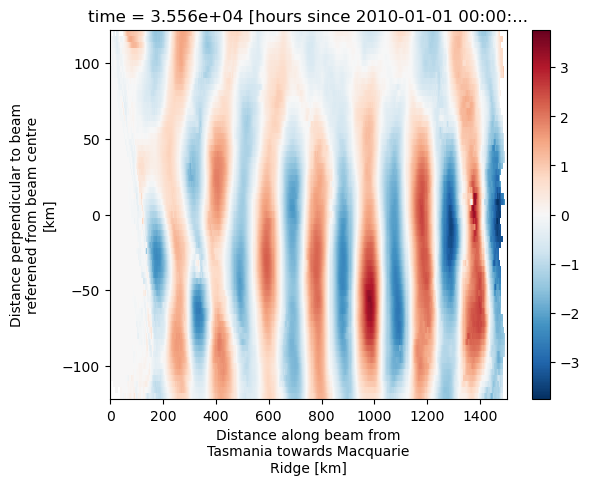

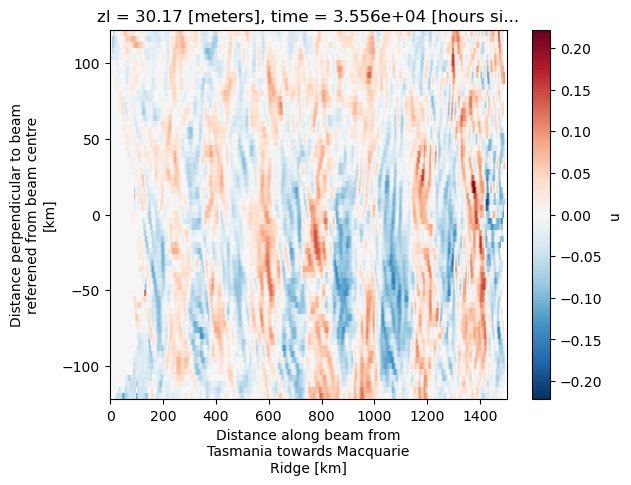

In [11]:
data = to_process["full-20-2"]["data"].u.persist()
efunc = xr.open_dataset("/g/data/nm03/ab8992/postprocessed/full-20/VerticalEigenfunctions.nc").chunk({"zl":-1,"xb" : 50,"yb" : 50}).persist()

mode1 = (data * efunc.U.isel(mode = 0)).integrate("zl").persist()

mode1.isel(time = 50).plot()
plt.figure()

data.isel(zl = 5,time = 50).plot()